In [98]:
# Importing pandas, sklearn, and matplotlib 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# Loading data into the dataframe 

# https://data.census.gov/table/ACSST1Y2022.S2503?q=San%20Diego%20County,%20California&t=Owner/Renter%20(Tenure)
census_data = pd.read_csv('CensusData.csv') 

# https://www.zillow.com/research/data/
zillow_price = pd.read_csv('ZillowPrice.csv')
zillow_rent = pd.read_csv('ZillowRent.csv')

# https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download
cahousing = pd.read_csv('CAhousing.csv') 

In [4]:
# Data visualization
cahousing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


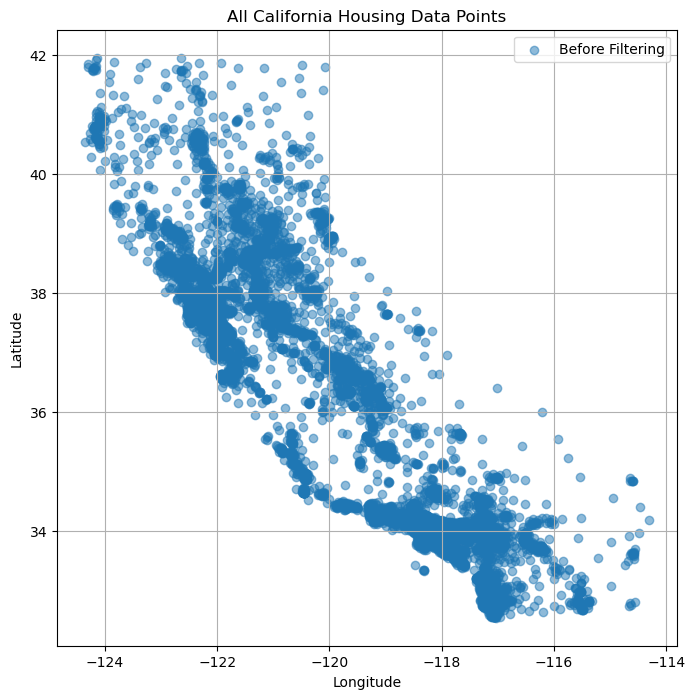

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter(cahousing['longitude'], cahousing['latitude'], alpha=0.5, label='Before Filtering')
plt.title('All California Housing Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Data cleansing 
# Filtering data to only display the San Diego Reigion 
sd_cahousing = cahousing[(cahousing['latitude'] >= 32.5) & (cahousing['latitude'] <= 33.5) &
                         (cahousing['longitude'] >= -117.3) & (cahousing['longitude'] <= -117)]

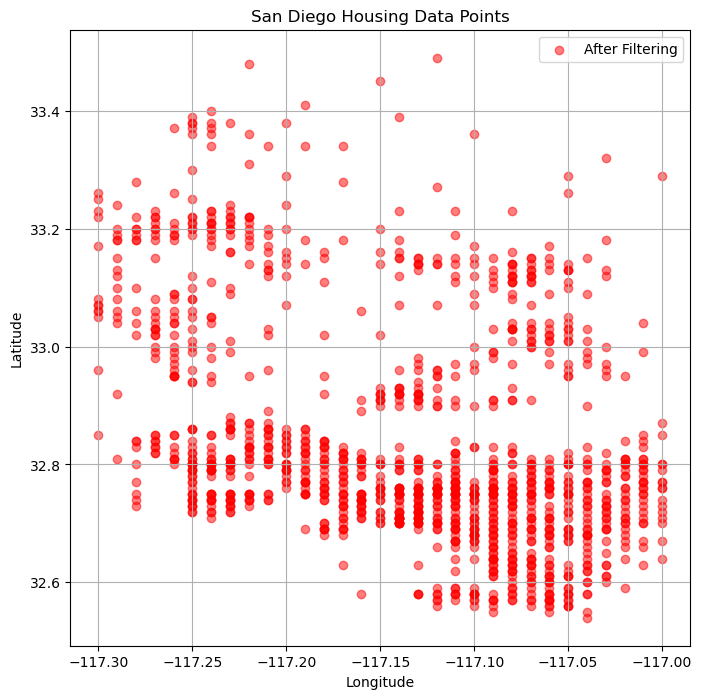

In [10]:
# Data visualization
plt.figure(figsize=(8, 8))
plt.scatter(sd_cahousing['longitude'], sd_cahousing['latitude'], color='red', alpha=0.5, label='After Filtering')
plt.title('San Diego Housing Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Calculate mean values for relevant columns
sd_avg_values = sd_cahousing[['median_house_value', 'median_income', 'housing_median_age', 'total_rooms',
                              'total_bedrooms', 'population', 'households']].mean()

# Calculate additional economic indicators
sd_avg_values['avgRoomsPerHousehold'] = sd_cahousing['total_rooms'] / sd_cahousing['households']
sd_avg_values['avgBedroomsPerHousehold'] = sd_cahousing['total_bedrooms'] / sd_cahousing['households']
sd_avg_values['avgPopulationPerHousehold'] = sd_cahousing['population'] / sd_cahousing['households']

# Print the results
print("San Diego Region - Average Values:")
print(sd_avg_values)

San Diego Region - Average Values:
median_house_value                                                197878.16194
median_income                                                         3.764696
housing_median_age                                                   24.454478
total_rooms                                                        2764.258955
total_bedrooms                                                      567.497358
population                                                         1449.965672
households                                                          531.973134
avgRoomsPerHousehold         12211    8.756906
12214    6.761378
12216    7...
avgBedroomsPerHousehold      12211    1.364641
12214    1.246925
12216    1...
avgPopulationPerHousehold    12211    2.817680
12214    2.713407
12216    3...
dtype: object


In [20]:
print(sd_avg_values.avgRoomsPerHousehold.mean())
print(sd_avg_values.avgBedroomsPerHousehold.mean())
print(sd_avg_values.avgPopulationPerHousehold.mean())

5.198288148470038
1.0573764617741797
2.7867660204089866


In [24]:
# Median Income according to this dataset 
med_income = sd_avg_values.median_income * 10000

#Actual Household = 98,657$ https://www.census.gov/quickfacts/fact/table/sandiegocitycalifornia/INC110222
actual_household_income = 98657

#Actual Individual = 51,368$ https://www.census.gov/quickfacts/fact/table/sandiegocitycalifornia/INC110222
actual_individual_income = 51368

# 30% Rule https://www.chase.com/personal/banking/education/budgeting-saving/how-much-income-should-go-to-rent#:~:text=A%20popular%20standard%20for%20budgeting,were%20%22cost%2Dburdened.%22
monthly_med_income = med_income / 12 
monthly_rent_cost = monthly_med_income * .30
print('Expected Montly Rent Cost by Data:', monthly_rent_cost)

monthly_household_income = actual_household_income / 12 
monthly_rent_cost2 = monthly_household_income * .30
print('Expected Montly Rent Cost by Household:', monthly_rent_cost2)

monthly_individual_income = actual_individual_income / 12 
monthly_rent_cost3 = monthly_individual_income * .30
print('Expected Montly Rent Cost by Census Individual Data:', monthly_rent_cost3)

Expected Montly Rent Cost by Data: 941.1739738805957
Expected Montly Rent Cost by Household: 2466.4249999999997
Expected Montly Rent Cost by Census Individual Data: 1284.2


In [ ]:
# Create a DataFrame for the regression analysis
sd_cahousing['avgRoomsPerHousehold'] = sd_cahousing['total_rooms'] / sd_cahousing['households']
sd_cahousing['avgBedroomsPerHousehold'] = sd_cahousing['total_bedrooms'] / sd_cahousing['households']
sd_cahousing['avgPopulationPerHousehold'] = sd_cahousing['population'] / sd_cahousing['households']

regression_df = sd_cahousing[['median_income', 'avgRoomsPerHousehold', 'avgBedroomsPerHousehold', 'avgPopulationPerHousehold']]

In [ ]:
# Data cleaning 
# Remove infinite values
regression_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
regression_df.dropna(inplace=True)

In [37]:
# Now split the data into features (X) and target (y)
X = regression_df[['avgRoomsPerHousehold', 'avgBedroomsPerHousehold', 'avgPopulationPerHousehold']]
y = regression_df['median_income']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [38]:
# Linear Regression 
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the medianIncome
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.8220931225766308


In [46]:
# Test the model to see my expected income for the place I am renting
custom_values = {
    'avgRoomsPerHousehold': 12,
    'avgBedroomsPerHousehold': 7,
    'avgPopulationPerHousehold': 7
}

custom_values_df = pd.DataFrame([custom_values])

# Make prediction
predicted_median_income = model.predict(custom_values_df)

predicted_median_income = -predicted_median_income * 10000

print(f"The predicted median income for the custom values is: {predicted_median_income[0]}")


The predicted median income for the custom values is: 88059.40380790677


In [58]:
# Data visualization
census_data.head()

,Label (Grouping),"San Diego County, California!!Occupied housing units!!Estimate","San Diego County, California!!Occupied housing units!!Margin of Error","San Diego County, California!!Percent occupied housing units!!Estimate","San Diego County, California!!Percent occupied housing units!!Margin of Error","San Diego County, California!!Owner-occupied housing units!!Estimate","San Diego County, California!!Owner-occupied housing units!!Margin of Error","San Diego County, California!!Percent owner-occupied housing units!!Estimate","San Diego County, California!!Percent owner-occupied housing units!!Margin of Error","San Diego County, California!!Renter-occupied housing units!!Estimate","San Diego County, California!!Renter-occupied housing units!!Margin of Error","San Diego County, California!!Percent renter-occupied housing units!!Estimate","San Diego County, California!!Percent renter-occupied housing units!!Margin of Error"
0,Occupied housing units,"1,172,343","±5,008","1,172,343","±5,008","639,298","±9,312","639,298","±9,312","533,045","±8,608","533,045","±8,608"
1,HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Less than $5,000","33,363","±3,828",2.8%,±0.3,"11,035","±2,211",1.7%,±0.3,"22,328","±2,809",4.2%,±0.5
3,"$5,000 to $9,999","17,075","±2,471",1.5%,±0.2,"6,385","±1,538",1.0%,±0.2,"10,690","±1,910",2.0%,±0.4
4,"$10,000 to $14,999","32,279","±3,231",2.8%,±0.3,"9,866","±1,545",1.5%,±0.2,"22,413","±3,023",4.2%,±0.5


In [63]:
#Had to reformat data in excel due to really inconsistent formatting 
monthly_housing_cost = pd.read_csv('mhc.csv') 
monthly_housing_cost_per_income = pd.read_csv('mhcpi.csv') 

In [64]:
monthly_housing_cost.head()

,Label (Grouping),"San Diego County, California!!Occupied housing units!!Estimate","San Diego County, California!!Occupied housing units!!Margin of Error","San Diego County, California!!Percent occupied housing units!!Estimate","San Diego County, California!!Percent occupied housing units!!Margin of Error","San Diego County, California!!Owner-occupied housing units!!Estimate","San Diego County, California!!Owner-occupied housing units!!Margin of Error","San Diego County, California!!Percent owner-occupied housing units!!Estimate","San Diego County, California!!Percent owner-occupied housing units!!Margin of Error","San Diego County, California!!Renter-occupied housing units!!Estimate","San Diego County, California!!Renter-occupied housing units!!Margin of Error","San Diego County, California!!Percent renter-occupied housing units!!Estimate","San Diego County, California!!Percent renter-occupied housing units!!Margin of Error"
0,Less than $300,"22,086","±2,397",1.90%,±0.2,"17,199","±2,182",2.70%,±0.3,"4,887","±1,224",0.90%,±0.2
1,$300 to $499,"39,615","±3,071",3.40%,±0.3,"31,870","±2,891",5.00%,±0.4,"7,745","±1,469",1.50%,±0.3
2,$500 to $799,"70,724","±4,352",6.00%,±0.4,"57,859","±3,546",9.10%,±0.6,"12,865","±2,408",2.40%,±0.4
3,$800 to $999,"46,064","±3,585",3.90%,±0.3,"34,955","±2,830",5.50%,±0.5,"11,109","±1,677",2.10%,±0.3
4,"$1,000 to $1,499","140,060","±5,767",11.90%,±0.5,"65,426","±3,938",10.20%,±0.6,"74,634","±4,656",14.00%,±0.8


In [ ]:
# Clean the 'Renter-occupied housing units' estimate column by removing commas and converting to integers
monthly_housing_cost['San Diego County, California!!Renter-occupied housing units!!Estimate'] = monthly_housing_cost[
    'San Diego County, California!!Renter-occupied housing units!!Estimate'].str.replace(',', '').astype(int)

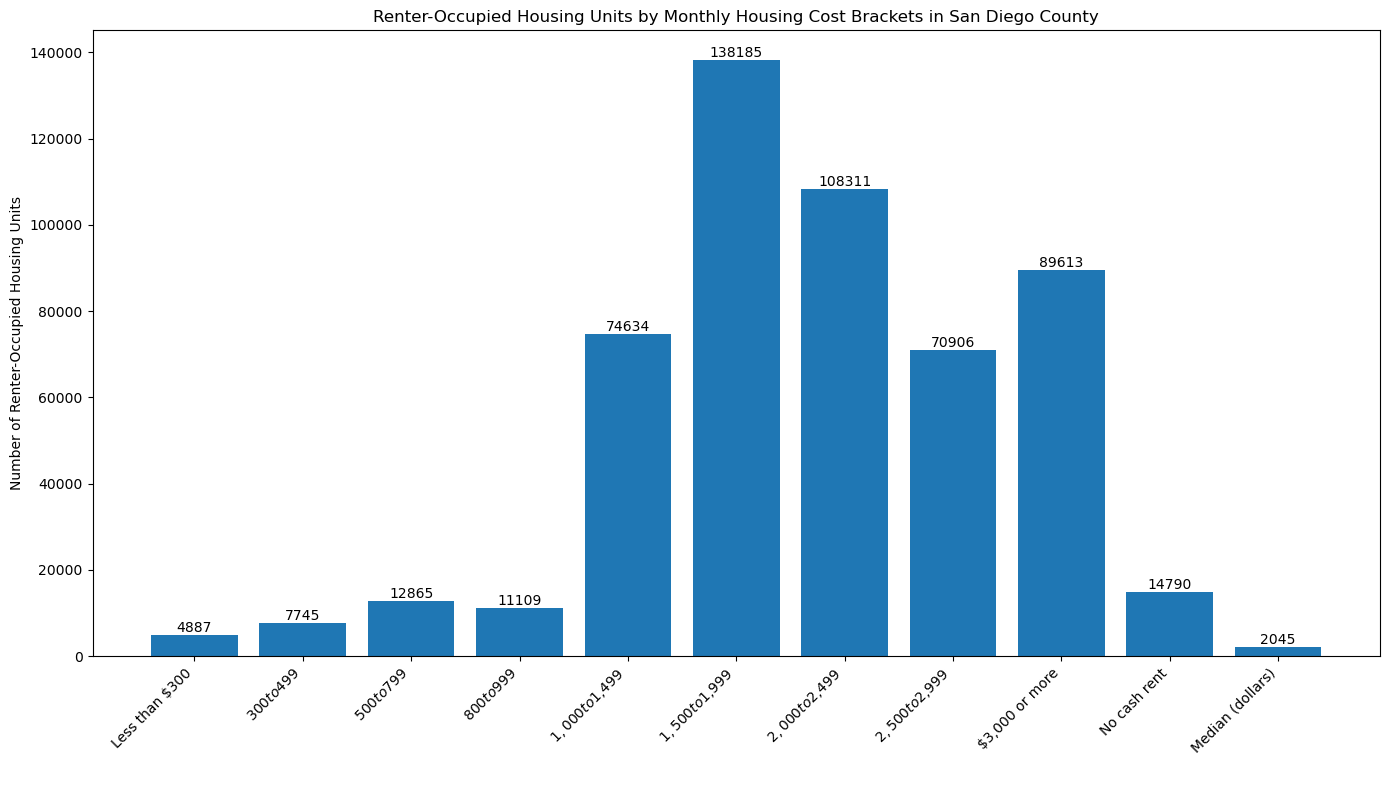

In [69]:
plt.figure(figsize=(14, 8))
bars = plt.bar(monthly_housing_cost['Label (Grouping)'], monthly_housing_cost['San Diego County, California!!Renter-occupied housing units!!Estimate'])

# Add labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Set the x-axis labels, rotating them for better visibility
plt.xticks(rotation=45, ha="right")

# Set the y-axis label and title
plt.ylabel('Number of Renter-Occupied Housing Units')
plt.title('Renter-Occupied Housing Units by Monthly Housing Cost Brackets in San Diego County')

plt.tight_layout()  # Adjust layout to ensure labels are visible
plt.show()

In [ ]:
# Clean the 'Percent renter-occupied housing units' estimate column by removing the percent sign and commas
# Convert it to float for pie chart percentages
monthly_housing_cost['San Diego County, California!!Percent renter-occupied housing units!!Estimate'] = (
    monthly_housing_cost['San Diego County, California!!Percent renter-occupied housing units!!Estimate']
    .str.replace('%', '')
    .str.replace(',', '')
    .astype(float)
)

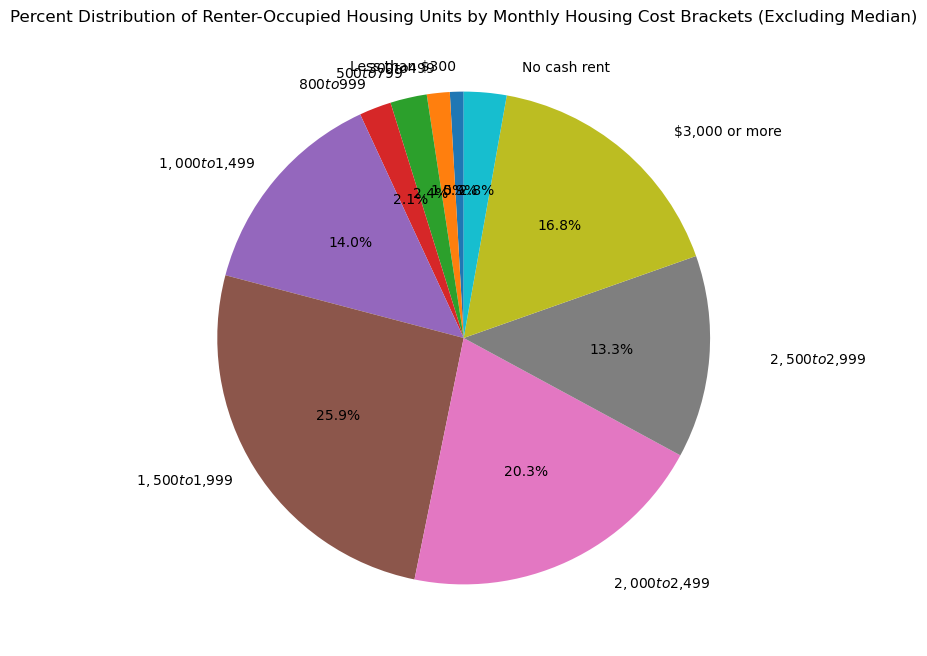

In [74]:
# Filtering the data to exclude 'Median (dollars)' row
pie_data_excluding_median = monthly_housing_cost[
    monthly_housing_cost['Label (Grouping)'].str.strip() != 'Median (dollars)'
]

# Create a pie chart with the filtered data
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    pie_data_excluding_median['San Diego County, California!!Percent renter-occupied housing units!!Estimate'],
    labels=pie_data_excluding_median['Label (Grouping)'],
    autopct='%1.1f%%',  # Format for the percentage labels
    startangle=90
)

# Set the title
ax.set_title('Percent Distribution of Renter-Occupied Housing Units by Monthly Housing Cost Brackets (Excluding Median)')

# Show the plot
plt.show()


In [75]:
# 90.3% of renters fall within the range 1000 to 3000+ 
# Using the census data above an individual would expect to pay 1284.2$ which just barely makes it in the range of 
# what renters are paying 
# Using the data we calculated from the first dataset an individual would expect to pay 941.17$ which would make 
# the average indiviual not qualify for 90.3% of rental units. 

In [76]:
monthly_housing_cost_per_income.head()

,Label (Grouping),"San Diego County, California!!Occupied housing units!!Estimate","San Diego County, California!!Occupied housing units!!Margin of Error","San Diego County, California!!Percent occupied housing units!!Estimate","San Diego County, California!!Percent occupied housing units!!Margin of Error","San Diego County, California!!Owner-occupied housing units!!Estimate","San Diego County, California!!Owner-occupied housing units!!Margin of Error","San Diego County, California!!Percent owner-occupied housing units!!Estimate","San Diego County, California!!Percent owner-occupied housing units!!Margin of Error","San Diego County, California!!Renter-occupied housing units!!Estimate","San Diego County, California!!Renter-occupied housing units!!Margin of Error","San Diego County, California!!Percent renter-occupied housing units!!Estimate","San Diego County, California!!Percent renter-occupied housing units!!Margin of Error"
0,"Less than $20,000","88,845","±5,452",7.60%,±0.5,"31,567","±2,751",4.90%,±0.4,"57,278","±4,933",10.70%,±0.9
1,"$20,000 to $34,999","92,711","±5,028",7.90%,±0.4,"34,757","±3,068",5.40%,±0.5,"57,954","±4,625",10.90%,±0.8
2,"$35,000 to $49,999","87,485","±5,149",7.50%,±0.4,"34,886","±3,033",5.50%,±0.5,"52,599","±4,190",9.90%,±0.8
3,"$50,000 to $74,999","160,524","±6,584",13.70%,±0.6,"69,907","±4,033",10.90%,±0.6,"90,617","±5,469",17.00%,±1.0
4,"$75,000 or more","714,075","±9,653",60.90%,±0.7,"462,916","±8,393",72.40%,±0.8,"251,159","±8,078",47.10%,±1.3


In [77]:
# Clean the 'Percent renter-occupied housing units' estimate column by removing the percent sign and commas
# Convert it to float for pie chart percentages
monthly_housing_cost_per_income['San Diego County, California!!Percent renter-occupied housing units!!Estimate'] = (
    monthly_housing_cost_per_income['San Diego County, California!!Percent renter-occupied housing units!!Estimate']
    .str.replace('%', '')
    .str.replace(',', '')
    .astype(float)
)

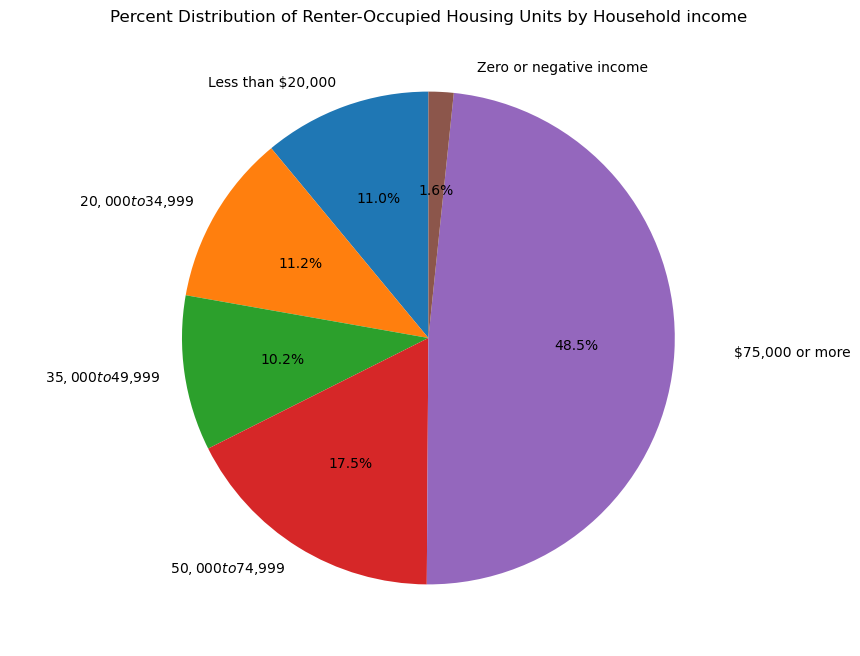

In [79]:
# Filtering the data to exclude 'Median (dollars)' row
pie_data_excluding_median = monthly_housing_cost_per_income[
    monthly_housing_cost_per_income['Label (Grouping)'].str.strip() != 'Median (dollars)'
]

# Create a pie chart with the filtered data
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    pie_data_excluding_median['San Diego County, California!!Percent renter-occupied housing units!!Estimate'],
    labels=pie_data_excluding_median['Label (Grouping)'],
    autopct='%1.1f%%',  # Format for the percentage labels
    startangle=90
)

# Set the title
ax.set_title('Percent Distribution of Renter-Occupied Housing Units by Household income')

# Show the plot
plt.show()

In [80]:
# In order to survive in San Diego based on this distribution most people are making 75,000+ to pay their monthly rent
# On top of this the average income 51368$ wouldn't put you even in the top 50%
# As a college student working a partime job it is basically impossible to make enough money to make it out of the blue

In [81]:
zillow_price.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,238929.371135,240200.909361,...,752211.597470,751314.782467,749404.785776,746874.468406,743779.049929,740924.105582,739638.954141,740127.905666,742197.880465,746451.344216
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,228164.787100,228510.253426,...,921167.944104,932705.537738,948506.773140,964693.096419,978019.705578,986930.857759,991811.950891,988633.437335,980930.778245,974104.683705
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,102112.819227,102086.875044,...,265524.273014,266477.771224,267446.784769,267908.811085,268064.567681,267908.310222,267702.704573,267926.554660,268444.956812,269461.096112
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,141884.310885,141922.218100,...,281805.293898,283077.006697,284874.340064,286600.873695,287643.719284,288140.327397,288052.602308,287969.487353,288470.116586,289908.808294
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,98118.182518,98209.273971,...,262935.169795,263160.151005,263296.951543,262849.105254,262003.335168,260736.100545,259223.621671,258120.478077,257547.405613,257710.869268


In [88]:
# Filter the DataFrame for the specified regions
region_filter = zillow_price['StateName'].isin(['CA'])
filtered_data = zillow_price[region_filter]

filtered_data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,228164.787100,228510.253426,...,9.211679e+05,9.327055e+05,9.485068e+05,9.646931e+05,9.780197e+05,9.869309e+05,9.918120e+05,9.886334e+05,9.809308e+05,9.741047e+05
8,54296,8,San Diego,city,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",San Diego County,225487.238977,226524.296175,...,9.419077e+05,9.545263e+05,9.682117e+05,9.819381e+05,9.929839e+05,1.000379e+06,1.003711e+06,1.006114e+06,1.011494e+06,1.021655e+06
11,33839,11,San Jose,city,CA,CA,"San Jose-Sunnyvale-Santa Clara, CA",Santa Clara County,345909.903482,347654.793400,...,1.330325e+06,1.349456e+06,1.374786e+06,1.402526e+06,1.427480e+06,1.446959e+06,1.460395e+06,1.462100e+06,1.459832e+06,1.461923e+06
17,20330,17,San Francisco,city,CA,CA,"San Francisco-Oakland-Berkeley, CA",San Francisco County,428177.003420,430359.522981,...,1.316651e+06,1.316225e+06,1.319064e+06,1.322146e+06,1.321848e+06,1.316860e+06,1.308280e+06,1.297880e+06,1.289466e+06,1.290678e+06
28,20288,28,Sacramento,city,CA,CA,"Sacramento-Roseville-Folsom, CA",Sacramento County,122614.310599,122947.672720,...,4.694109e+05,4.723406e+05,4.758515e+05,4.781004e+05,4.794054e+05,4.800540e+05,4.804913e+05,4.808063e+05,4.814388e+05,4.834554e+05


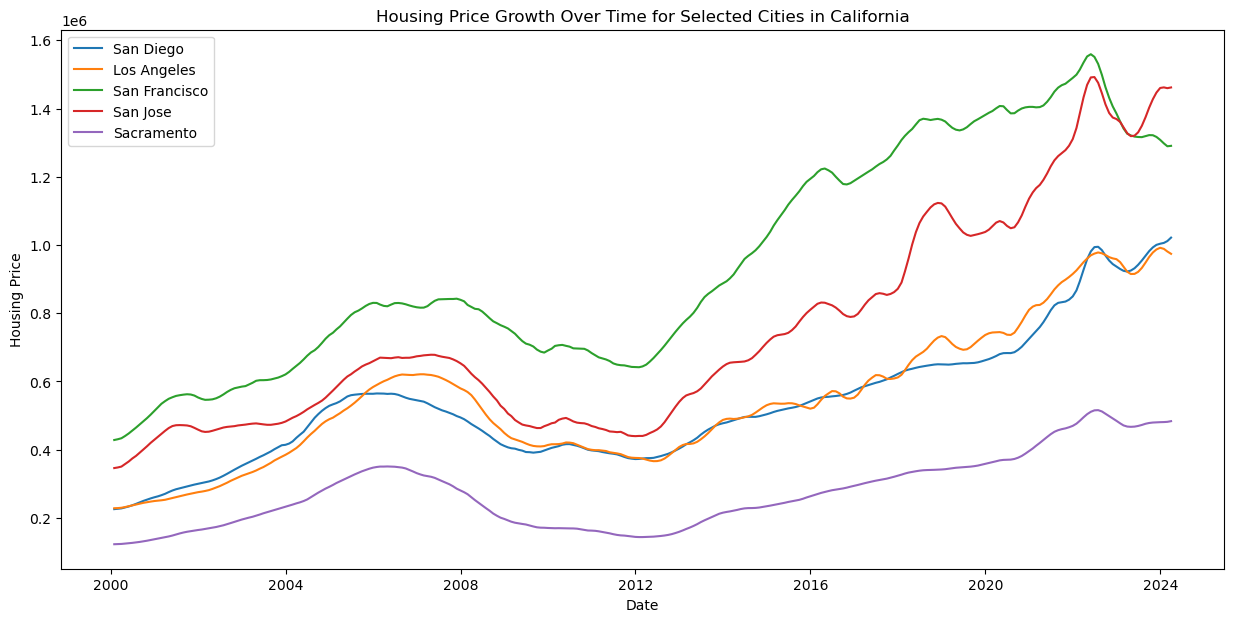

In [90]:
# Define the cities to plot
cities = ['San Diego', 'Los Angeles', 'San Francisco', 'San Jose', 'Sacramento']

# Initialize a figure
plt.figure(figsize=(15, 7))

# Loop through each city and plot the data
for city in cities:
    # Filter the DataFrame for the city
    city_data = filtered_data[filtered_data['RegionName'] == city]
    
    # Melt the DataFrame to "long" format with 'Date' and 'Price' columns
    city_data_long = pd.melt(city_data, 
                             id_vars=['RegionName'], 
                             value_vars=city_data.columns[8:],  # Assuming date columns start at index 7
                             var_name='Date', 
                             value_name='Price')
    
    # Convert 'Date' to datetime
    city_data_long['Date'] = pd.to_datetime(city_data_long['Date'])
    
    # Sort the data by date
    city_data_long = city_data_long.sort_values(by='Date')
    
    # Plot the data
    plt.plot(city_data_long['Date'], city_data_long['Price'], label=city)

# Add title and labels
plt.title('Housing Price Growth Over Time for Selected Cities in California')
plt.xlabel('Date')
plt.ylabel('Housing Price')
plt.legend()

# Show plot
plt.show()

In [91]:
# As we can see in recent times there has been large increases in the average housing price in all of california
# San Diego is no exception with current average housing prices exceding 1 millon far from what most can afford
# As we can also see this raises the question if the increase in cost is not just a San Diego thing but a California thing

In [92]:
zillow_rent.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2015-01-31,2015-02-28,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2573.879708,2589.306004,...,3460.697523,3492.108861,3502.622625,3499.522406,3475.886121,3438.555242,3407.910597,3402.315084,3423.725988,3461.971276
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,1849.059453,1865.004206,...,2801.052686,2805.469172,2813.306352,2813.581824,2806.599738,2791.442684,2777.691936,2781.813008,2785.944206,2803.489527
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,1201.964989,1205.385158,...,1580.146729,1588.320683,1587.617871,1585.287405,1581.733298,1580.430165,1580.766493,1580.921612,1582.594952,1583.266787
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,1550.072380,1559.748446,...,2093.653837,2106.831499,2110.652982,2099.884180,2083.817514,2068.071635,2070.689604,2085.273431,2107.845065,2126.400264
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,982.170629,986.525801,...,1435.808612,1436.555969,1436.840829,1433.162399,1424.425273,1417.375874,1412.549726,1411.220510,1411.643867,1417.456969


In [93]:
# Filter the DataFrame for the specified regions
region_filter2 = zillow_rent['RegionName'].isin(['San Diego'])
filtered_data2 = zillow_rent[region_filter2]

filtered_data2.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2015-01-31,2015-02-28,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
8,54296,8,San Diego,city,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",San Diego County,1722.644675,1733.891138,...,3026.038013,3050.736491,3054.771777,3050.278349,3034.550253,3014.501057,2992.134025,2976.298273,2981.212453,2999.846604


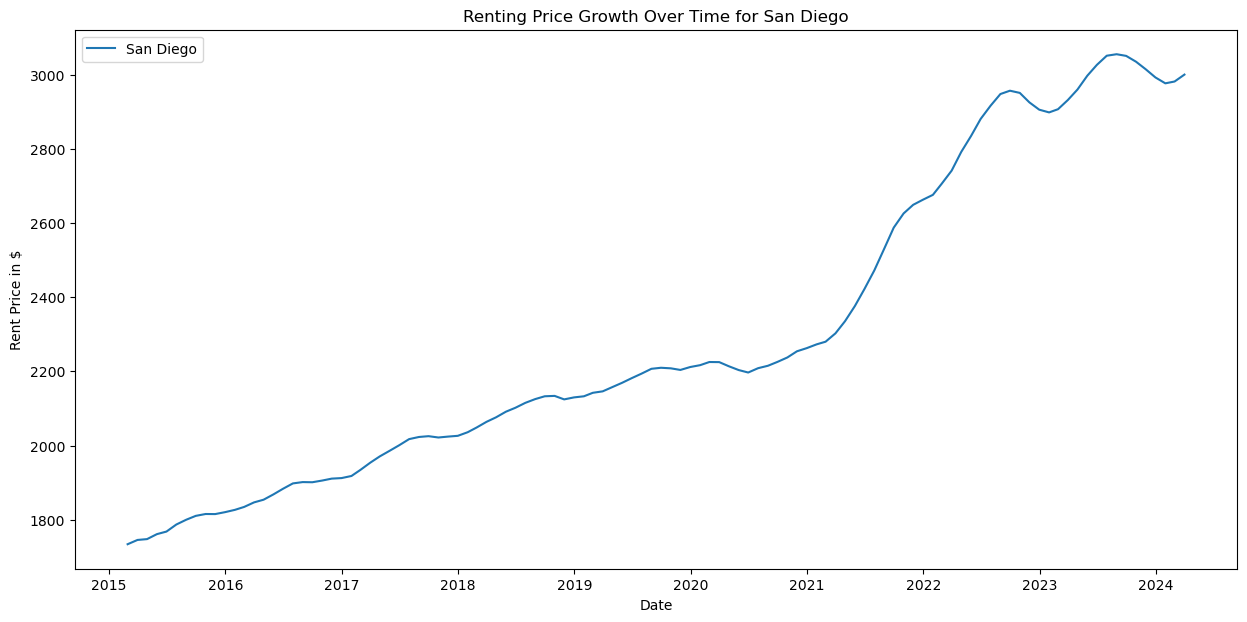

In [95]:
# Define the cities to plot
cities = ['San Diego']

# Initialize a figure
plt.figure(figsize=(15, 7))

# Loop through each city and plot the data
for city in cities:
    # Filter the DataFrame for the city
    city_data = filtered_data2[filtered_data2['RegionName'] == city]
    
    # Melt the DataFrame to "long" format with 'Date' and 'Price' columns
    city_data_long = pd.melt(city_data, 
                             id_vars=['RegionName'], 
                             value_vars=city_data.columns[9:],  # Assuming date columns start at index 7
                             var_name='Date', 
                             value_name='Price')
    
    # Convert 'Date' to datetime
    city_data_long['Date'] = pd.to_datetime(city_data_long['Date'])
    
    # Sort the data by date
    city_data_long = city_data_long.sort_values(by='Date')
    
    # Plot the data
    plt.plot(city_data_long['Date'], city_data_long['Price'], label=city)

# Add title and labels
plt.title('Renting Price Growth Over Time for San Diego')
plt.xlabel('Date')
plt.ylabel('Rent Price in $')
plt.legend()

# Show plot
plt.show()

In [96]:
# Zillow Observed Rent Index (ZORI): A smoothed measure of the typical observed market rate rent across a given 
# region. ZORI is a repeat-rent index that is weighted to the rental housing stock to ensure representativeness 
# across the entire market, not just those homes currently listed for-rent. The index is dollar-denominated by 
# computing the mean of listed rents that fall into the 40th to 60th percentile range for all homes and apartments 
# in a given region, which is weighted to reflect the rental housing stock.

In [97]:
# As we can see above the rent in San Diego is growing exponentially after 2021 which hints at inflation / market saturation
# With this continuted growth rent could soon become unafforable for most people in the reigion 
# This would include most SDSU students who rent houses around the campus 

Mean Squared Error: 882.9374455332107
Predicted Future Rent Price: 2997.056427631147


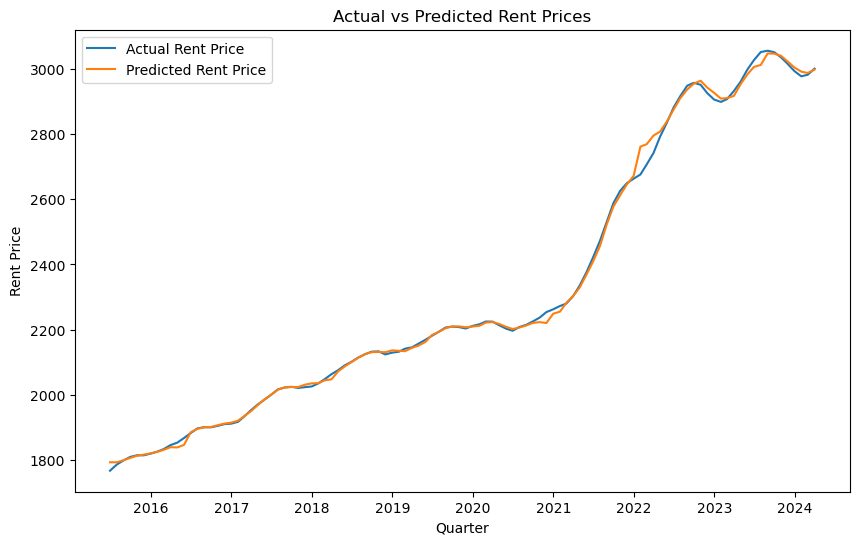

In [99]:
df = filtered_data2.iloc[:, 9:]  # Assuming rent price data starts from the 10th column

# Transpose the DataFrame to have dates as rows and regions as columns
df = df.transpose()

# Convert the index to datetime format
df.index = pd.to_datetime(df.index)

# Feature Engineering
# Let's create lag features, i.e., the rent prices of the previous quarters
for i in range(1, 5):
    df[f'Price_Lag_{i}'] = df.iloc[:, 0].shift(i)

# Drop rows with NaN values (due to the lag)
df.dropna(inplace=True)

# Split data into features (X) and target variable (y)
X = df.drop(df.columns[0], axis=1)  # Features are all lag prices
y = df[df.columns[0]]  # Target variable is the current price

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Predict future rent prices
# Let's use the last available data point to predict the future rent prices
last_data_point = X.iloc[[-1]]
future_rent_price = model.predict(last_data_point)
print(f'Predicted Future Rent Price: {future_rent_price[0]}')

# Visualize actual vs predicted rent prices
plt.figure(figsize=(10, 6))
plt.plot(df.index, y, label='Actual Rent Price')
plt.plot(df.index, model.predict(X), label='Predicted Rent Price')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Quarter')
plt.ylabel('Rent Price')
plt.legend()
plt.show()